In [1]:
import numpy as np
from qwanta import Experiment
import matplotlib.pyplot as plt
import pandas as pd
from math import radians, cos, sin, asin, sqrt

In [2]:
loss = 0.001 # dB/km
p_dep = [0.97, 0.01, 0.01, 0.01] # independent with distant
gateErr =  [0.9975, 0.0025]
meaErr = 0.03

# Memory error
def memError(time, tau=0.5):
    p = (np.e**(-1*(time/tau)))/4 + 0.75
    return [p, (1- p)/3, (1- p)/3, (1- p)/3]

exp_names = ['EPPS']

def time_to_coordinate(t):
    return (50*np.sin(7/50)*t + 100,0,0)

# def distance(lat1, lat2, lon1, lon2):
#     lon1 = radians(lon1)
#     lon2 = radians(lon2)
#     lat1 = radians(lat1)
#     lat2 = radians(lat2)

#     dlon = lon2-lon1
#     dlat = lat2-lat1
#     a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
#     c = 2*asin(sqrt(a))
#     r_e = 6371
#     return (c*r_e)

def ISS_orbit(t):
    # [5.71756095e+01 1.06960339e+00 8.52707152e-01 4.88544727e-04]
    
    lat_t = 57.18*sin(radians(1.07*t + 8.53)) + 4.89
    lon_t = 3.63*t - 22.58
    r_iss = 6771
    x = r_iss*np.cos(lat_t)*np.cos(lon_t)
    y = r_iss*np.cos(lat_t)*np.sin(lon_t)
    z = r_iss*np.sin(lat_t)

    return (x, y, z)

def earth_location(lat, lon):
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    r_e = 6371
    x = r_e*np.cos(lat)*np.cos(lon)
    y = r_e*np.cos(lat)*np.sin(lon)
    z = r_e*np.sin(lat)
    return (x, y, z)

# def LEO2(t):
#     y = 50*np.sin(2*t)
#     z = 200 + 10*np.sin(2*t)
#     return (0, y, z)

# 13°45'53.0"N 100°31'31.6"E  mahidol
# 35°38'56.3"N 139°44'34.6"E  keio
# 18.804982, 98.954428  chiangmai
# 7.213724, 100.594990 songkra

In [5]:
x1, y1, z1 = earth_location(13.4553, 100.31316)
x2, y2, z2 = earth_location(18.804982, 98.954428)
dis = sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2*2))
dis

213.73136926666913

In [8]:


nodes_info_exp = [{
            'Node 0': {'coordinate': earth_location(13.4553, 100.31316)}, # BKK
            'Node 1': {'coordinate': ISS_orbit},
            'Node 2': {'coordinate': earth_location(7.213724, 100.594990)}, # SK
            'numPhysicalBuffer': 20,
            'numInternalEncodingBuffer': 20,
            'numInternalDetectingBuffer': 10,
            'numInternalInterfaceBuffer': 2,
        },
        # {
        #     'Node 0': {'coordinate': earth_location(7.213724, 100.594990)}, # SK
        #     'Node 1': {'coordinate': ISS_orbit},
        #     'Node 2': {'coordinate': earth_location(18.804982, 98.954428)}, # CM
        #     'numPhysicalBuffer': 20,
        #     'numInternalEncodingBuffer': 20,
        #     'numInternalDetectingBuffer': 10,
        #     'numInternalInterfaceBuffer': 2,
        # },
        # {
        #     'Node 0': {'coordinate': earth_location(13.4553, 100.31316)}, # BKK
        #     'Node 1': {'coordinate': ISS_orbit},
        #     'Node 2': {'coordinate': earth_location(35.38563, 139.44346)}, # Keio
        #     'numPhysicalBuffer': 20,
        #     'numInternalEncodingBuffer': 20,
        #     'numInternalDetectingBuffer': 10,
        #     'numInternalInterfaceBuffer': 2,
        # },
        ]

Quantum_topology = [{
        ('Node 0', 'Node 1'): {
        'connection-type': 'Space',
        'function': p_dep,
        'loss': loss,
        'light speed': 300000, # km/s
        'Pulse rate': 0.0001, # waiting time for next qubit (interval)
        },
        ('Node 1', 'Node 2'): {
        'connection-type': 'Space',
        'function': p_dep,
        'loss': loss,
        'light speed': 300000,
        'Pulse rate': 0.0001,
        },
        ('Node 0', 'Node 2'): {
        'connection-type': 'Space',
        'function': p_dep,
        'loss': loss,
        'light speed': 300000,
        'Pulse rate': 0.0001,
        },
    }
for _ in exp_names]


timelines = {}
for exp_name in exp_names:
    e_tl, vis_a = Experiment.read_timeline_from_csv(f'experssdp.xlsx', excel=True, sheet_name=exp_name) 
    timelines[exp_name] = e_tl
    
e_tl[2]['Resource Type'] = 'Physical'
e_tl[2]['Edges'] = ['Node 0', 'Node 2']
e_tl[2]['Num Trials'] = 9000

nodes_information = {exp_name: nodes_info_exp[index] for index, exp_name in enumerate(exp_names)}
networks = {exp_name: Quantum_topology[index] for index, exp_name in enumerate(exp_names)}
mem_func = {exp_name: memError for exp_name in exp_names}
gate_error = {exp_name: gateErr for exp_name in exp_names}
measure_error = {exp_name: meaErr for exp_name in exp_names}
sim_time = {exp_name: None for exp_name in exp_names}
labels = {exp_name: 'Physical' for exp_name in exp_names}

p = [0]
exper = Experiment(networks, timelines, measurementError=measure_error, nodes_info=nodes_information, memFunc=mem_func, gateError=gate_error, simTime=sim_time,
                parameters_set=p, collect_fidelity_history=True, repeat=5, 
                label_records=labels,path='BKK_SK_0.001_err', message_log='epps', progress_bar=True)

In [9]:
exper.run()

Experiments executed:   0%|          | 0/1 [00:00<?, ?it/s]

Parameters executed:   0%|          | 0/1 [00:00<?, ?it/s]

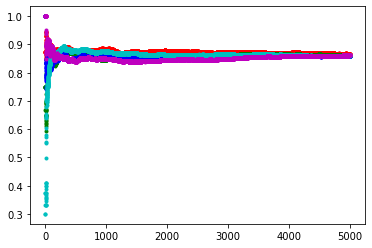

In [10]:
init = 0
x = np.linspace(init, 5000, len(exper.results()['EPPS'][0][0]['Fidelity History'][init:]))
plt.plot(x, exper.results()['EPPS'][0][0]['Fidelity History'][init:], '.r')
plt.plot(x, exper.results()['EPPS'][0][1]['Fidelity History'][init:], '.g')
plt.plot(x, exper.results()['EPPS'][0][2]['Fidelity History'][init:], '.b')
plt.plot(x, exper.results()['EPPS'][0][3]['Fidelity History'][init:], '.c')
plt.plot(x, exper.results()['EPPS'][0][4]['Fidelity History'][init:], '.m')
plt.show()

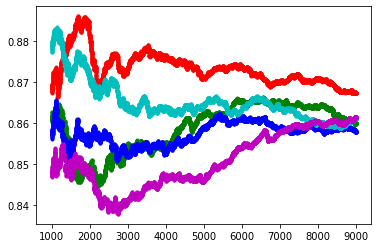

In [12]:
init = 1000
final = 9000
x = np.linspace(init, final, len(exper.results()['EPPS'][0][0]['Fidelity History'][init:]))
plt.plot(x, exper.results()['EPPS'][0][0]['Fidelity History'][init:], '.r')
plt.plot(x, exper.results()['EPPS'][0][1]['Fidelity History'][init:], '.g')
plt.plot(x, exper.results()['EPPS'][0][2]['Fidelity History'][init:], '.b')
plt.plot(x, exper.results()['EPPS'][0][3]['Fidelity History'][init:], '.c')
plt.plot(x, exper.results()['EPPS'][0][4]['Fidelity History'][init:], '.m')
plt.show()

In [13]:
len(exper.results()['EPPS'][0][0]['Fidelity History'])

9001

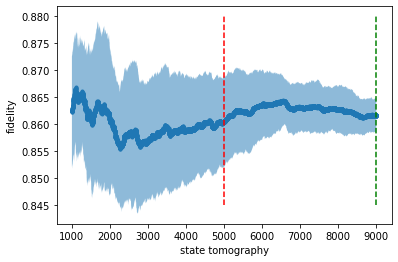

In [20]:
avg_ssdp = []
exper_result = exper.results()['EPPS'][0]
init = 1000
final = 9000

avg_ssdp.append(exper_result[0]['Fidelity History'][init:])
avg_ssdp.append(exper_result[1]['Fidelity History'][init:])
avg_ssdp.append(exper_result[2]['Fidelity History'][init:])
avg_ssdp.append(exper_result[3]['Fidelity History'][init:])
avg_ssdp.append(exper_result[4]['Fidelity History'][init:])
avg_ssdp = np.array(avg_ssdp)

mean_ssdp = avg_ssdp.mean(axis=0)
std_ssdp = avg_ssdp.std(axis=0)

plt.plot(np.linspace(init, final+1, final+1-init), mean_ssdp, '.')
plt.fill_between(np.linspace(init, final+1, final+1-init), mean_ssdp-std_ssdp, mean_ssdp+std_ssdp, alpha=0.5)
plt.xlabel('state tomography')
plt.ylabel('fidelity')
plt.plot([5000]*2, [0.845, 0.880], '--r')
plt.plot([9000]*2, [0.845, 0.880], '--g')
plt.show()